In [414]:
import csv
import pandas as pd
import numpy as np
np.random.seed(1)
from itertools import islice
from copy import deepcopy
import ast
import joblib
import datapreprocess #my own pipeline for data preprocessing... i usually use this for prototyping
reload(datapreprocess)
import dataviz as dv
reload(dv)
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
%matplotlib inline  

from __future__ import print_function

In [2]:
data = pd.read_csv('ratings_sample.tsv', sep = '\t')

In [3]:
data.head(5)

,like,player_id,subject_id,player_age,player_height,player_age_max,player_age_min,player_distance_max,player_height_min,player_height_max,...,player_location,subject_gender_orientation,subject_hometown,subject_metro,subject_location,distance,player_saved,player_rated,subject_saved,subject_rated
0,0.0,8273b4e96e0a1c2dba27e648c58c188489fab7f4,4f261692e5d9c9d5df3044f5bf198decb10fef37,28,160,34,27,38,92,214,...,Entertainment_District,MS,Charlotte_North_Carolina,Charlotte,Piper_Glen_Estates,597.758599,0,0,0,0
1,0.0,8273b4e96e0a1c2dba27e648c58c188489fab7f4,a4bdbd52034a4da46b38fce744a18314c91126ba,28,160,34,27,38,92,214,...,Entertainment_District,MS,Guaynabo_Puerto_Rico,Orlando,Casselberry,1044.507045,0,0,0,0
2,0.0,8273b4e96e0a1c2dba27e648c58c188489fab7f4,0ccb0938d8b28a83f371a3d8daed480104e41bc5,28,160,34,27,38,92,214,...,Entertainment_District,MS,Los_Angeles_California,Los_Angeles,West_Puente_Valley,2160.723454,0,0,0,0
3,0.0,8273b4e96e0a1c2dba27e648c58c188489fab7f4,646520beed19eef482cb3829a163fd934ee156de,28,160,34,27,38,92,214,...,Entertainment_District,FS,Haymarket_Virginia,New_York_City,Park_Slope,345.084733,0,0,0,0
4,0.0,b37022aa5cbd49723c02f932079b1da940740618,96ad25457abd5ae2f095450cbf0e3ee2818e6b7f,32,158,38,28,100,92,214,...,High_Park_North,FS,Tenafly_New_Jersey,New_York_City,Hoboken,343.625159,0,0,0,0


## Data Exploration

1.	How many users are in this dataset? What percentage of users appear both as a player and a subject?
2. How often do players like people outside of their declared preferences?
3.	Did you find any other anomalies in the data?




In [7]:
event_rate = data['like'].sum() / float(len(data.index))
event_rate

0.17553014100482664

In [8]:
mean_stats = data.groupby('like').mean()
mean_stats

,player_age,player_height,player_age_max,player_age_min,player_distance_max,player_height_min,player_height_max,subject_age,subject_height,subject_age_max,subject_age_min,subject_distance_max,subject_height_min,subject_height_max,distance,player_saved,player_rated,subject_saved,subject_rated
like,,,,,,,,,,,,,,,,,,,
0.0,28.992002,173.352927,35.336145,23.960311,57.933121,97.418746,212.409362,28.576677,171.478315,35.003931,24.120800,69.557525,94.260318,213.418252,98.638464,22.588034,125.309325,25.791258,166.804081
1.0,28.841193,177.186976,35.561303,22.445489,58.844424,96.167818,211.942707,27.284998,168.892888,34.192061,24.679052,67.227943,95.371187,213.692465,122.051134,14.267273,126.712124,62.211424,164.821466


In [9]:
unique_players = data.player_id.unique()
unique_subjects = data.subject_id.unique()
both_player_subject = list(set(unique_players) & set(unique_subjects))
total_users = list(set(unique_players) | set(unique_subjects))
total_records = len(data.index)

print('Unique Players:', len(unique_players))
print('Unique Subjects:', len(unique_subjects))
print('Users that are both Player and Subject:', len(both_player_subject))
print('Total Users:', len(total_users))
print('% Both Player and Subject: {0:.2f}%'.format(float(len(both_player_subject)) / len(total_users) * 100))
print('Total Records:', total_records)


Unique Players: 2762
Unique Subjects: 19942
Users that are both Player and Subject: 2735
Total Users: 19969
% Both Player and Subject: 13.70%
Total Records: 500763


In [10]:
anomalies = {'age': 0.0, 'height': 0.0, 'distance': 0.0, 'sex': 0.0}
players = {}

#populate players dictionary
for player in unique_players:
    players[player] = deepcopy(anomalies)
    
print('Head(5) of Players dictionary:')
[print('\t',i) for i in [k for k in players.iteritems()][:5]]

#this will be the reference of how many soft preferences are successful for each player and show which criteria contributed to it

Head(5) of Players dictionary:
	 ('f49010139a67489eed87cf1697cbcf158d49f7d7', {'distance': 0.0, 'age': 0.0, 'height': 0.0, 'sex': 0.0})
	 ('ef69ff38588f25ff69d440337df92eba9e7ad15a', {'distance': 0.0, 'age': 0.0, 'height': 0.0, 'sex': 0.0})
	 ('0ba9b6e184676ff3cbe197960f9d0b8841d9b866', {'distance': 0.0, 'age': 0.0, 'height': 0.0, 'sex': 0.0})
	 ('380e6dfc4b19eaa7a39972a47d303c1990d28d98', {'distance': 0.0, 'age': 0.0, 'height': 0.0, 'sex': 0.0})
	 ('ce7de91e523ddb40c17ea4335cc24cc3d369db49', {'distance': 0.0, 'age': 0.0, 'height': 0.0, 'sex': 0.0})


[None, None, None, None, None]

In [11]:
straight = ['FS', 'MS']
gay = ['FG', 'MG']
bi = ['FB', 'MB']
total_anomalies = 0.0

'''
    assumptions:
            - if straight: preference is straight
            - if gay: preference is straight,gay,bi of same gender
            - if bi: preference is straight, gay, bi of both genders
'''
for i in range(total_records):
    if i % 10000 == 0:
        print(i,'/',total_records, 'Total Anomalies:', total_anomalies)
    if data.iloc[i,0] == 1:
        current_player = data.iloc[i,1]
        current_player_age_range = range(data.iloc[i,6],data.iloc[i,5]+1)
        current_player_max_distance = data.iloc[i,7]
        current_player_height_range = range(data.iloc[i,8],data.iloc[i,9]+1)

        if data.iloc[i,17] in straight:
            if data.iloc[i,17][0] == 'F':
                current_player_preferred_sex = [straight[1]]
            else:
                current_player_preferred_sex = [straight[0]]
        elif data.iloc[i,17] in gay:
            if data.iloc[i,17][0] == 'F':
                current_player_preferred_sex = [gay[0], straight[0], bi[0]]
            else:
                current_player_preferred_sex = [gay[1], straight[1], bi[1]]
        else:
            current_player_preferred_sex = list(data.player_gender_orientation.unique())

        current_subject_age = data.iloc[i,10]
        current_subject_height = data.iloc[i,11]
        current_subject_sex = data.iloc[i,21]
        current_subject_distance = data.iloc[i,25]

        if current_subject_age not in current_player_age_range or current_subject_height not in current_player_height_range or current_subject_sex not in current_player_preferred_sex or current_subject_distance > current_player_max_distance:
            total_anomalies += 1
            if current_subject_age not in current_player_age_range:
                players[current_player]['age'] += 1
                anomalies['age'] += 1
            if current_subject_height not in current_player_height_range:
                players[current_player]['height'] += 1
                anomalies['height'] += 1
            if current_subject_sex not in current_player_preferred_sex:
                players[current_player]['sex'] += 1
                anomalies['sex'] += 1
            if current_subject_distance > current_player_max_distance:
                players[current_player]['distance'] += 1
                anomalies['distance'] += 1

0 / 500763 Total Anomalies: 0.0
10000 / 500763 Total Anomalies: 1012.0
20000 / 500763 Total Anomalies: 1473.0
30000 / 500763 Total Anomalies: 1867.0
40000 / 500763 Total Anomalies: 2281.0
50000 / 500763 Total Anomalies: 2729.0
60000 / 500763 Total Anomalies: 3170.0
70000 / 500763 Total Anomalies: 3579.0
80000 / 500763 Total Anomalies: 4068.0
90000 / 500763 Total Anomalies: 4497.0
100000 / 500763 Total Anomalies: 4865.0
110000 / 500763 Total Anomalies: 5175.0
120000 / 500763 Total Anomalies: 5615.0
130000 / 500763 Total Anomalies: 6102.0
140000 / 500763 Total Anomalies: 6595.0
150000 / 500763 Total Anomalies: 7350.0
160000 / 500763 Total Anomalies: 7835.0
170000 / 500763 Total Anomalies: 8275.0
180000 / 500763 Total Anomalies: 8928.0
190000 / 500763 Total Anomalies: 9319.0
200000 / 500763 Total Anomalies: 9672.0
210000 / 500763 Total Anomalies: 10090.0
220000 / 500763 Total Anomalies: 10557.0
230000 / 500763 Total Anomalies: 10960.0
240000 / 500763 Total Anomalies: 11475.0
250000 / 5007

In [12]:
print('Head(5) of Players dictionary:')
[print('\t',i) for i in [k for k in players.iteritems()][:5]]
print('Breakdown of anomalies',anomalies)
print('Total Anomalies',total_anomalies)
print('Total Anomaly-Like Ratio', total_anomalies/data.like.sum())
[print('\t',key.title(),'Anomaly-Like Ratio', anomalies[key]/data.like.sum()) for key in anomalies]

Head(5) of Players dictionary:
	 ('f49010139a67489eed87cf1697cbcf158d49f7d7', {'distance': 0.0, 'age': 0.0, 'height': 0.0, 'sex': 0.0})
	 ('ef69ff38588f25ff69d440337df92eba9e7ad15a', {'distance': 5.0, 'age': 0.0, 'height': 0.0, 'sex': 0.0})
	 ('0ba9b6e184676ff3cbe197960f9d0b8841d9b866', {'distance': 1.0, 'age': 0.0, 'height': 0.0, 'sex': 0.0})
	 ('380e6dfc4b19eaa7a39972a47d303c1990d28d98', {'distance': 2.0, 'age': 0.0, 'height': 0.0, 'sex': 0.0})
	 ('ce7de91e523ddb40c17ea4335cc24cc3d369db49', {'distance': 0.0, 'age': 0.0, 'height': 0.0, 'sex': 0.0})
Breakdown of anomalies {'distance': 14111.0, 'age': 4899.0, 'sex': 3808.0, 'height': 601.0}
Total Anomalies 20921.0
Total Anomaly-Like Ratio 0.238011809008
	 Distance Anomaly-Like Ratio 0.160536524875
	 Age Anomaly-Like Ratio 0.0557344224621
	 Sex Anomaly-Like Ratio 0.0433224496297
	 Height Anomaly-Like Ratio 0.00683739291687


[None, None, None, None]

## Model Selection and Methodology

### Model Selection
For this quick prototype, I thought it was best to start with something simple to test my theories. In order to hit two birds (classification and feature importance) with one stone, I opted to use a random forest model, as it is able to provide me with the sorted feature importance early on in the experiment.

### Methodology
1. Individually remove some categorical variables that I believe are redundant, such as the player_hometown and location. For this implementation, the metro variable will do.
2. Introduction of *relational variables*. Since the outcome of the record is the interplay of the variables of two different people, it would be better to combine some variables to produce a more meaningful experiment. I also included flags for anomalies (like despite having soft preference) to test if the explicit observation of these occurrences will be help.
3. Preprocess categorical data. This mainly entails one-hot encoding. I used my own pipeline, one that I use for prototyping with my own projects. This step already takes care of missing value handling.
4. Separate train and test sets.
5. Preprocess numerical data of the train set and produce a mapper. Apply the mapper on the test set. This prevents potential information leakage from the train set to test set.
6. Fit the train set into the Random Forest classifier and produce the predictions.
7. Measure the performance using Accuracy Score, AUC Score, Recall, Precision, F-1 Score, and other standard classification metrics.
8. Extract the feature importance list produced by the Random Forest model.
9. Run RandomsearchGridCV to get best mix of hyperparameters.

In [117]:
[print(x,':',len(data[x].unique())) for x in ['player_hometown',
 'player_metro',
 'player_location',
 'subject_hometown',
 'subject_metro',
 'subject_location']]

player_hometown : 628
player_metro : 3
player_location : 330
subject_hometown : 5086
subject_metro : 58
subject_location : 4280


[None, None, None, None, None, None]

In [112]:
v = dv.Viz(data)

In [123]:
data['player_metro'].value_counts()

Toronto          496858
New_York_City      3435
Other               470
Name: player_metro, dtype: int64

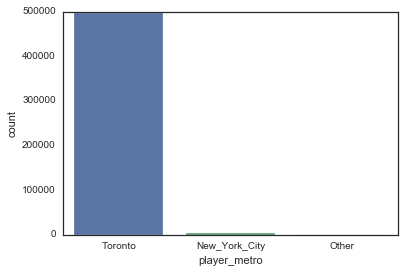

In [113]:
v.countplot(column = 'player_metro')

In [122]:
data['subject_metro'].value_counts()

Toronto                 378218
Other                    59695
Buffalo                  28184
Rochester                12940
New_York_City             3694
Los_Angeles               3420
San_Francisco             2535
Washington_D.C.           2334
London                    1809
Vancouver                  704
Chicago                    685
Mumbai                     656
Minneapolis_St._Paul       555
Houston                    458
Boston                     441
Montreal                   436
Detroit                    409
Dallas                     395
Cleveland                  322
Philadelphia               292
Pittsburgh                 291
Atlanta                    273
Seattle                    267
San_Diego                  247
Austin_San_Antonio         236
Calgary                    191
Denver                     149
Las_Vegas                  145
Miami                       82
Phoenix                     60
Columbus                    59
Tampa                       54
Portland

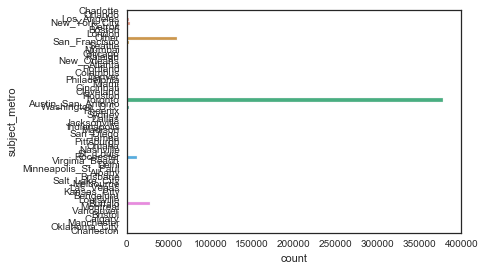

In [120]:
v.countplot(column = 'subject_metro', orient = 'h')

In [415]:
data2 = data.ix[:,[x for x in list(data.columns) if x not in ['player_id', 'subject_id','player_hometown','player_location','subject_hometown','subject_location']]]#,'player_saved', 'player_rated','subject_saved','subject_rated']]]

#introduction of relational variables
data2.ix[:,'player_subject_age_ratio'] = data2['player_age'] / pd.to_numeric(data2['subject_age'])
data2.ix[:,'player_subject_height_ratio'] = data2['player_height'] / pd.to_numeric(data2['subject_height'])
data2.ix[:,'player_age_is_older'] = np.where(data2['player_subject_age_ratio'] > 1, 1,0)
data2.ix[:,'player_height_is_taller'] = np.where(data2['player_subject_height_ratio'] > 1, 1,0)
data2.ix[:,'exceeds_max_distance'] = np.where(data2['distance'] > data2['player_distance_max'], 1,1)

#appearance of anomalies
data2.ix[:,'not_in_preferred_age_range'] = np.where(data2['subject_age'] < data2['player_age_min'], 1,0)
data2.ix[:,'not_in_preferred_age_range'] = np.where(data2['subject_age'] > data2['player_age_max'], 1,0)
data2.ix[:,'not_in_preferred_height_range'] = np.where(data2['subject_height'] < data2['player_height_min'], 
                                                       1,0)
data2.ix[:,'not_in_preferred_height_range'] = np.where(data2['subject_height'] > data2['player_height_max'], 
                                                       1,0)

In [416]:
data2.dtypes

like                             float64
player_age                         int64
player_height                      int64
player_age_max                     int64
player_age_min                     int64
player_distance_max                int64
player_height_min                  int64
player_height_max                  int64
subject_age                        int64
subject_height                     int64
subject_age_max                    int64
subject_age_min                    int64
subject_distance_max               int64
subject_height_min                 int64
subject_height_max                 int64
player_gender_orientation         object
player_metro                      object
subject_gender_orientation        object
subject_metro                     object
distance                         float64
player_saved                       int64
player_rated                       int64
subject_saved                      int64
subject_rated                      int64
player_subject_a

In [417]:
binary = []
for i in list(data2.columns):
    if len(data2[i].unique()) <= 2:
        print ('binary:', i)
        binary.append(i)

binary: like
binary: player_age_is_older
binary: player_height_is_taller
binary: exceeds_max_distance
binary: not_in_preferred_age_range
binary: not_in_preferred_height_range


In [418]:
categories =  datapreprocess.get_categorical_columns(data2)
numbers = datapreprocess.get_numerical_columns(data2)
numbers = [col for col in numbers if col not in binary]
categories.extend(['like'])
numbers.extend(['like'])

In [419]:
viz_n = dv.Viz(data2.ix[:,numbers])
viz_c = dv.Viz(data2.ix[:,categories])
viz_b = dv.Viz(data2.ix[:,binary])

# UNIVARIATE ANALYSIS

- we will be looking at the distributions of binary and categorical variables to see if there are some variables that are imbalanced. these might be treated differently later on.
- we see that 
    - we have an imbalanced dataset
    - all observations have exceeds_max_distance = 1
    - a chunk of the users (players and subjects) are skewed towards a certain label
    - there are also a lot of variables that barely look anything like a normal distribution

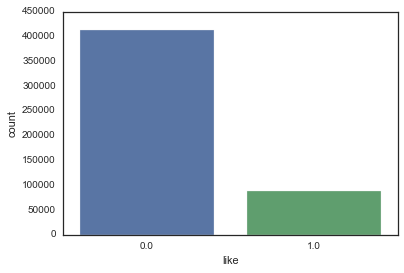

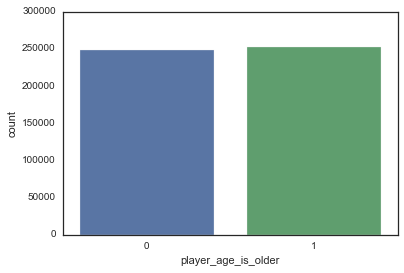

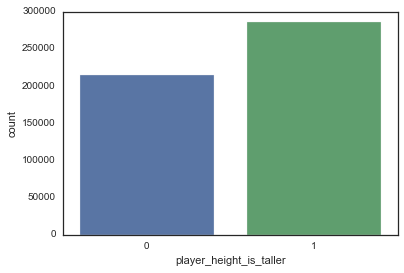

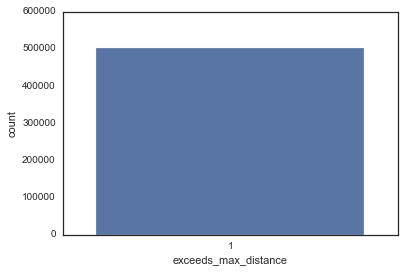

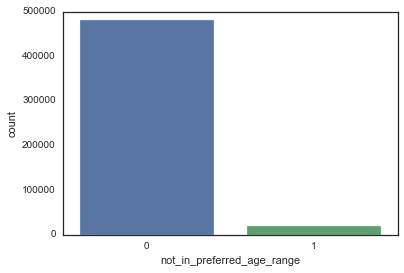

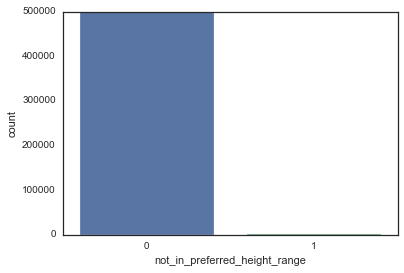

In [420]:
for i in binary:
    viz_b.countplot(i)
    plt.show()

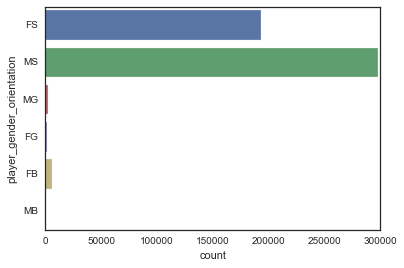

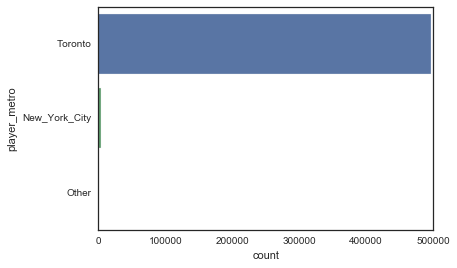

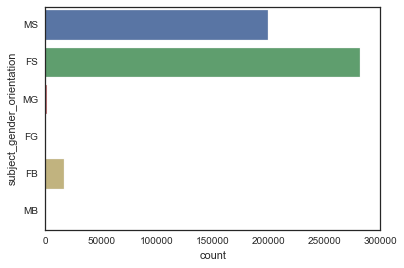

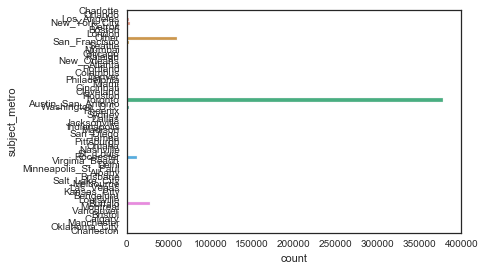

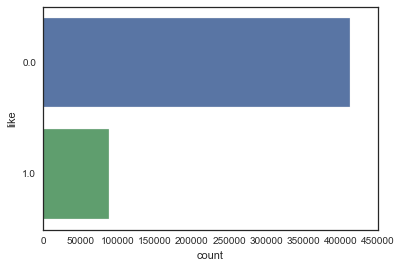

In [421]:
for i in categories:
    viz_c.countplot(i, orient = 'h')
    plt.show()

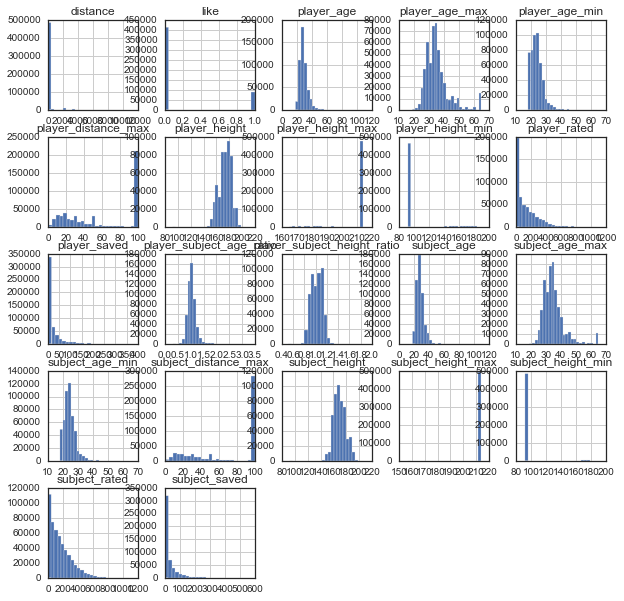

In [422]:
viz_n.histogram()

# Multivariate Analysis

- Here we see that there is a disparity in terms of scale due to the distance variable; we will need to scale this down
- we can also see high +/- correlation between newly constructed relational variables and their original root variables; I have decided to remove the root variables
- We were also able to determine, in a bird's eye view that the best, across the board, transformation method uses np.log10

In [423]:
dv.help()

class: Viz(df)
                self.df
                functions:
                    .scatterplot(x,y,size,mode)
                    .jointplot(x,y,size,kind)
                    .facetgrid(x,y,color_column,size,legend)
                    .pairplot(columns,color_column,size,diag_kind,kind)
                    .boxplot(x,y,size,orient)
                    .boxplot_all(orient,size)
                    .histogram(size,bins,grid)
                    .hist_one(column,size,bins)
                    .barplot(x,y,color_column)
                    .countplot(column,orient)
                    .bubble(x,y,size_column)
            


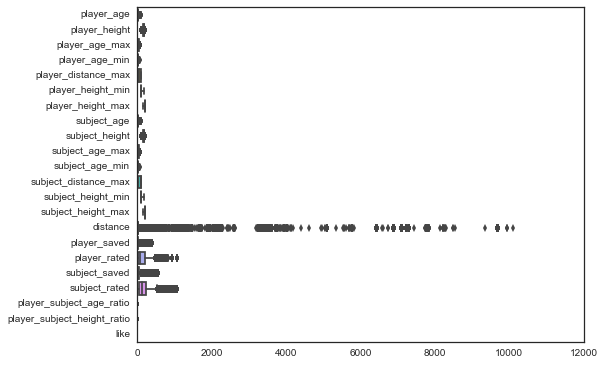

In [424]:
viz_n.boxplot_all('h')

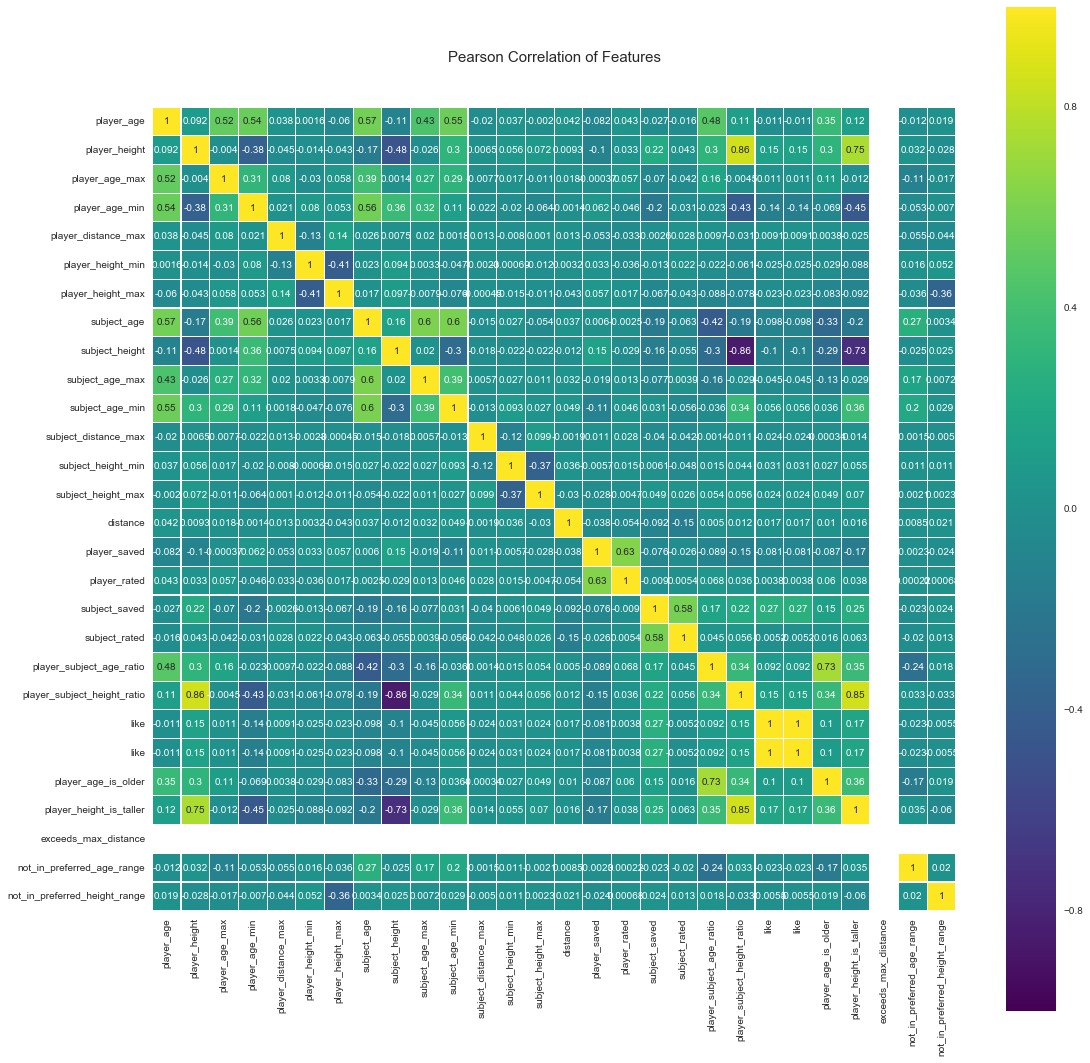

In [425]:
colormap = plt.cm.viridis
plt.figure(figsize=(18,18))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data2.ix[:,numbers+binary].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [426]:
redundant_features = ['player_height','subject_height','player_age', 'subject_age']

In [427]:
data2 = data2.ix[:,[x for x in data2.columns if x not in redundant_features]]

In [428]:
data_y = data2['like']
data_x = data2.iloc[:,1:]

In [430]:
#transform categorical variables using one-hot encoding
data_x2, mapper_cat, num_cols = datapreprocess.preprocess_cat(data_x)

Variables: From 26 to 26


In [432]:
data3 = pd.concat([data_y, data_x2], axis = 1)

In [433]:
data3.head()

,like,player_age_max,player_age_min,player_distance_max,player_height_min,player_height_max,subject_age_max,subject_age_min,subject_distance_max,subject_height_min,...,subject_metro_48.0,subject_metro_49.0,subject_metro_50.0,subject_metro_51.0,subject_metro_52.0,subject_metro_53.0,subject_metro_54.0,subject_metro_55.0,subject_metro_56.0,subject_metro_57.0
0,0.0,34.0,27.0,38.0,92.0,214.0,34.0,23.0,100.0,92.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,34.0,27.0,38.0,92.0,214.0,30.0,21.0,30.0,92.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,34.0,27.0,38.0,92.0,214.0,45.0,29.0,100.0,92.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,34.0,27.0,38.0,92.0,214.0,30.0,23.0,10.0,92.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,38.0,28.0,100.0,92.0,214.0,30.0,24.0,50.0,92.0,...,0,0,0,0,0,0,0,0,0,0


In [434]:
#split dataset 
test_sample = 0.2
slice_row = int(len(data3.index)*(1-test_sample))
train = data3.iloc[:slice_row,:]
test = data3.iloc[slice_row:,:]

In [435]:
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]

In [436]:
numbers.remove('like')

In [437]:
numbers = [x for x in numbers if x not in redundant_features]

In [438]:
viz = dv.Viz(train_x.ix[:,numbers])

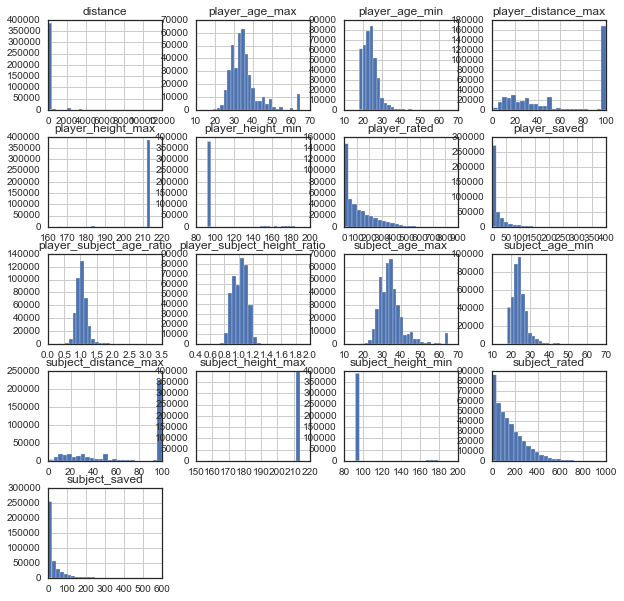

In [439]:
viz.histogram()

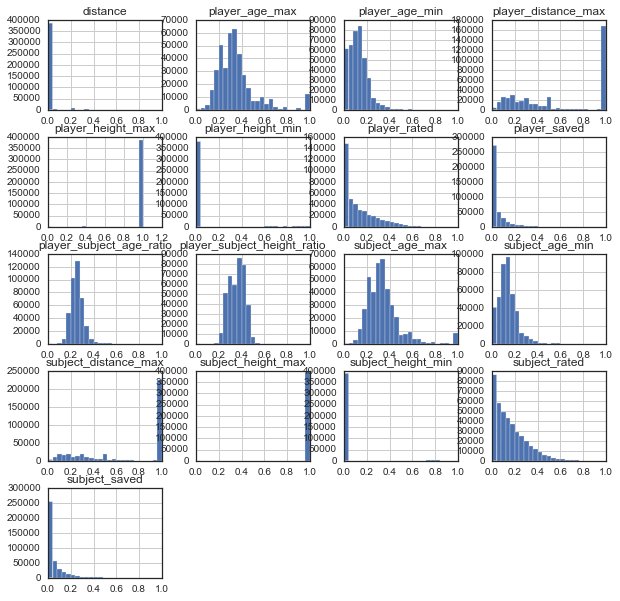

In [440]:
#transform numerical variables of train and test sets separately to avoid leakage
train_x, mapper_num, means_dict, std_dict = datapreprocess.preprocess_num(train_x, num_cols)
viz = dv.Viz(train_x.ix[:,numbers])
viz.histogram()

In [441]:
def plus_one(x):
    return x+1

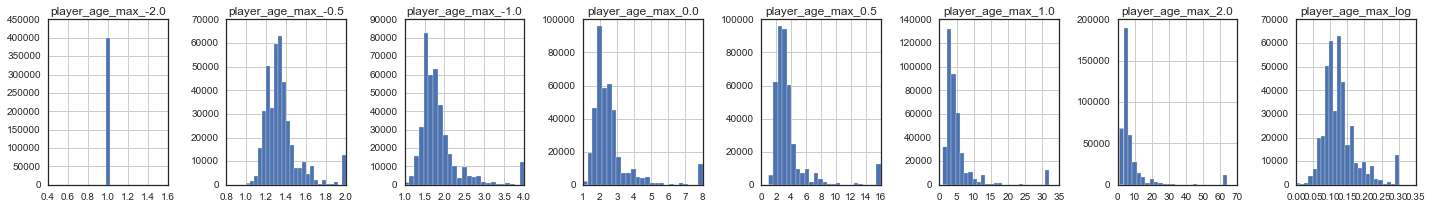

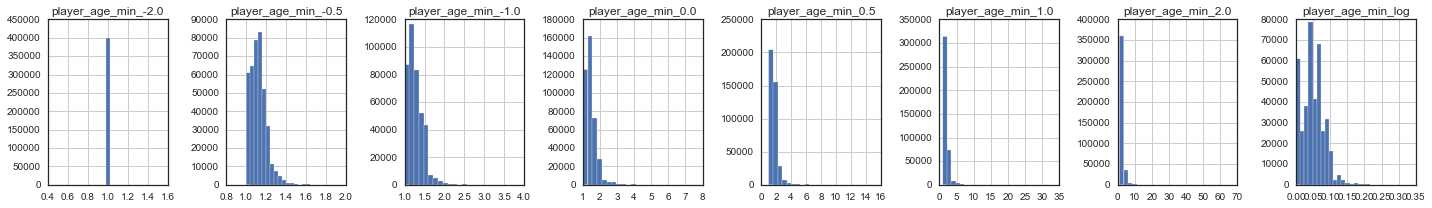

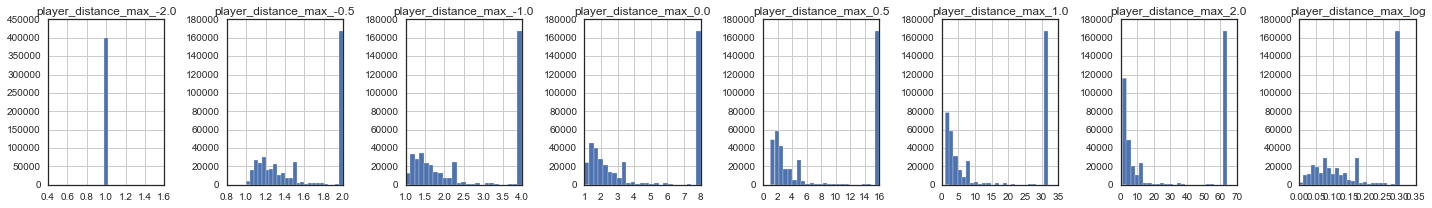

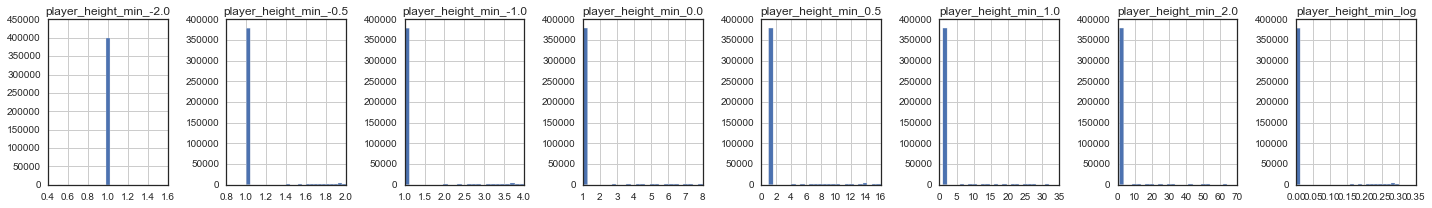

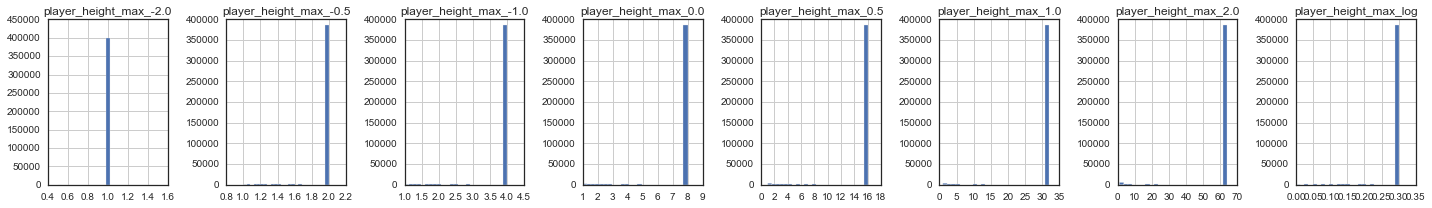

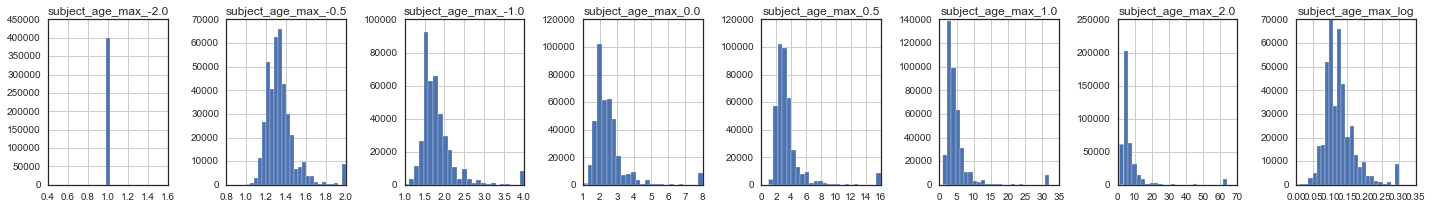

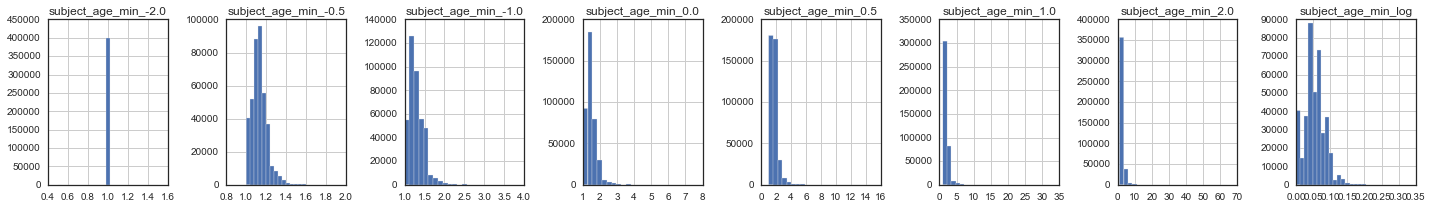

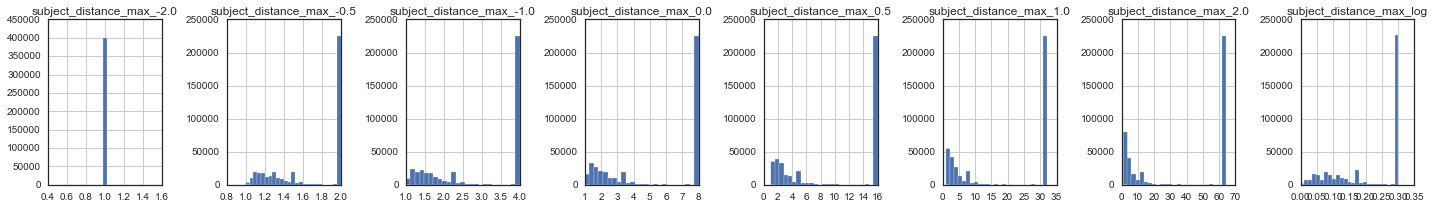

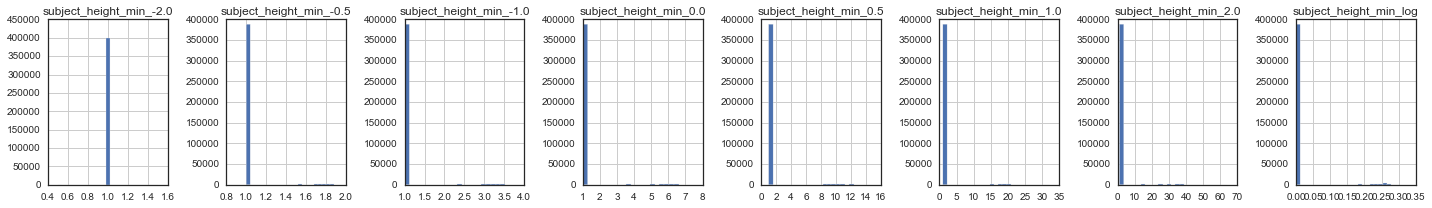

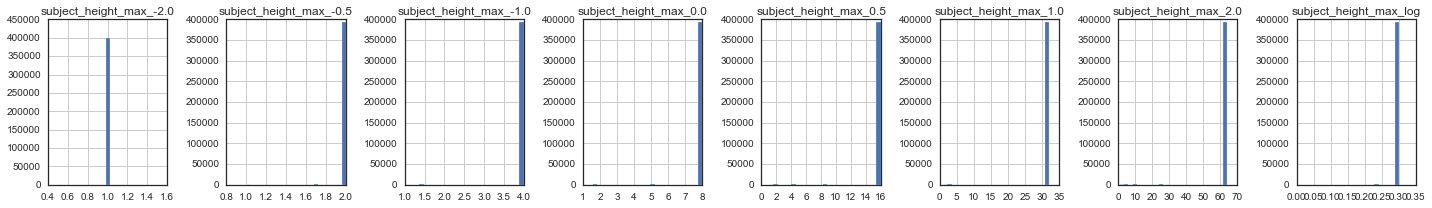

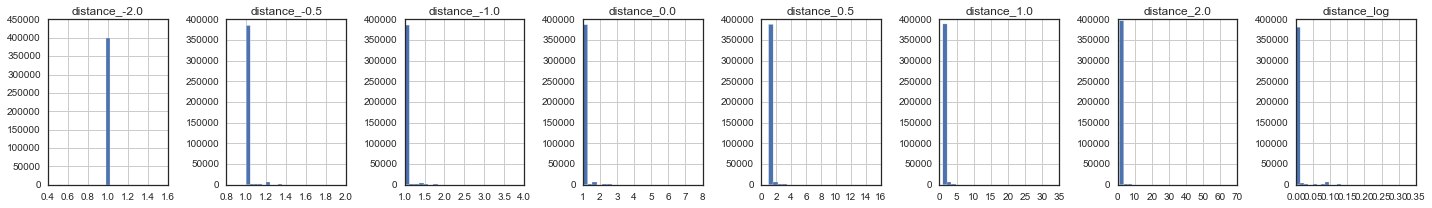

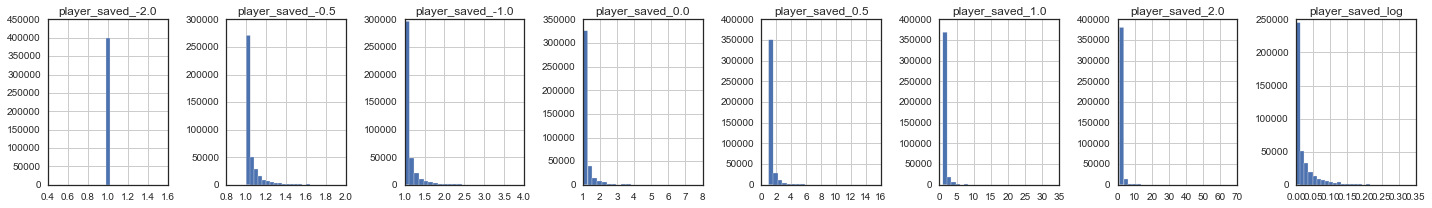

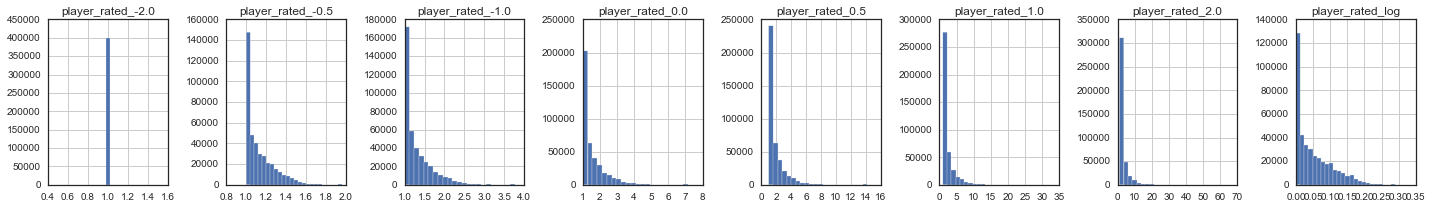

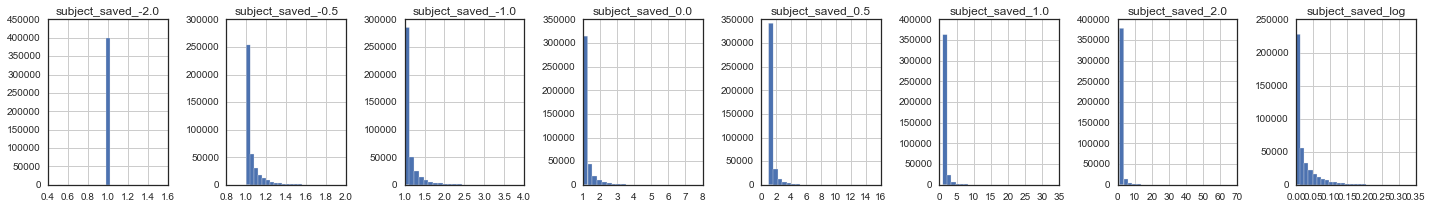

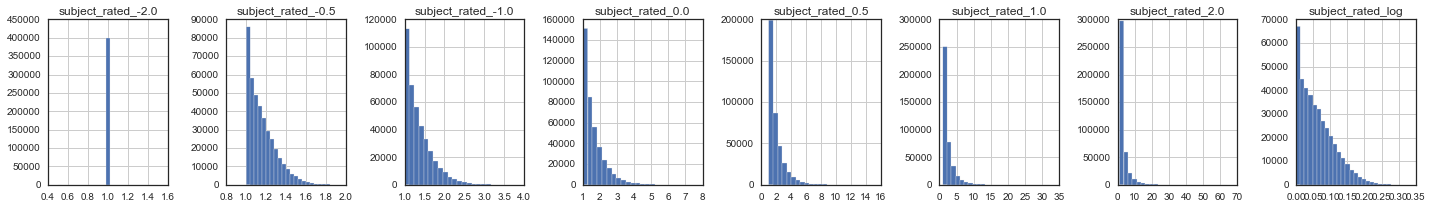

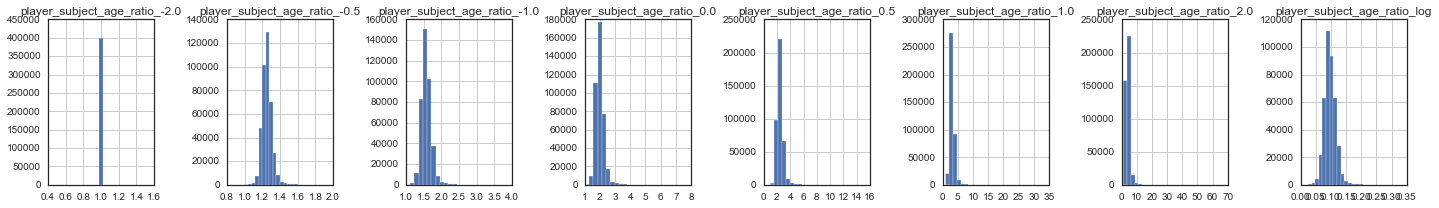

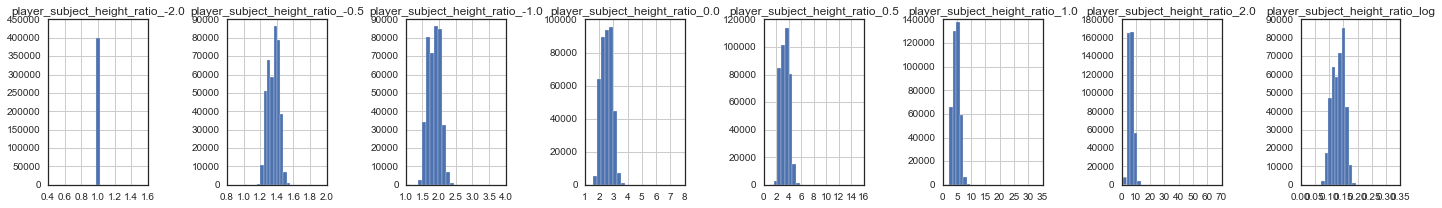

In [442]:
#determine the best way to transform the non-normally distributed variables
lmbdas = [-2.0,-0.5, -1.0, 0.0, 0.5, 1.0, 2.0, 'log']
for i in numbers:
    fig = plt.figure()
    for j,k in enumerate(lmbdas):
        transformations = deepcopy(train_x)
        ax = fig.add_subplot(1, len(lmbdas), j+1)
        transformations.ix[:,i] = transformations.ix[:,i].apply(plus_one)
        if k == 'log':
            transformations.ix[:,i] = transformations.ix[:,i].apply(np.log10)
        else:
            transformations.ix[:,i] = transformations.ix[:,i] ** j
        transformations[i].hist(bins = 25, ax = ax, figsize = (20,3))
        ax.set_title(i+'_'+str(k))
    fig.tight_layout()
    plt.show()

In [443]:
# it looks like the best way to transform the variables based on our search space is using np.log10
for i in numbers:
    train_x.ix[:,i] = train_x.ix[:,i].apply(plus_one)
    train_x.ix[:,i] = train_x.ix[:,i].apply(np.log10)
    
test_x = mapper_num.transform(test_x)
for i in numbers:
    test_x.ix[:,i] = test_x.ix[:,i].apply(plus_one)
    test_x.ix[:,i] = test_x.ix[:,i].apply(np.log10)

In [445]:
#format column names to prevent errors
train_x.columns = train_x.columns.str.replace(".0", "")
train_x.columns = train_x.columns.str.replace(" ", "_")
train_x.columns = train_x.columns.str.replace("(", "_")
train_x.columns = train_x.columns.str.replace(")", "_")
train_x.columns = train_x.columns.str.replace("__", "_")
train_x.columns = train_x.columns.str.replace("-", "_")

test_x.columns = test_x.columns.str.replace(".0", "")
test_x.columns = test_x.columns.str.replace(" ", "_")
test_x.columns = test_x.columns.str.replace("(", "_")
test_x.columns = test_x.columns.str.replace(")", "_")
test_x.columns = test_x.columns.str.replace("__", "_")
test_x.columns = test_x.columns.str.replace("-", "_")

In [446]:
train_y = np.ravel(train_y)
test_y = np.ravel(test_y)

In [447]:
#baseline model
rf = RandomForestClassifier(random_state = None)
rf.fit(train_x, train_y)
predicted_rf = rf.predict(test_x)
prob_rf = rf.predict_proba(test_x)

In [448]:
print('AUC Score: {0:.3f}'.format(metrics.roc_auc_score(test_y,prob_rf[:,1])))
print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(test_y, predicted_rf)))
print('Precision: {0:.3f}'.format(metrics.precision_score(test_y, predicted_rf)))
print('Recall: {0:.3f}'.format(metrics.recall_score(test_y, predicted_rf)))
print(metrics.classification_report(test_y, predicted_rf))
pd.crosstab(test_y,predicted_rf, rownames = ['Actual'],colnames = ['Predicted'], margins = True)

AUC Score: 0.752
Accuracy: 0.862
Precision: 0.458
Recall: 0.174
             precision    recall  f1-score   support

        0.0       0.88      0.97      0.92     86769
        1.0       0.46      0.17      0.25     13384

avg / total       0.83      0.86      0.83    100153



Predicted,0.0,1.0,All
Actual,,,
0.0,84010,2759,86769
1.0,11051,2333,13384
All,95061,5092,100153


In [449]:
sensitivity = 2333.0/13384
specificity = 84010.0/86769
print('Sensitivity: \t',sensitivity)
print('Specificity: \t',specificity)

Sensitivity: 	 0.174312612074
Specificity: 	 0.968202929618


In [450]:
featurenames = train_x.columns
featureimportance = rf.feature_importances_
feature_importance_list = pd.DataFrame(featureimportance, index = featurenames, columns = ['importance'])

In [451]:
feature_importance_list.sort_values(by = ['importance'], ascending = False)[:10]

,importance
subject_saved,0.147637
subject_rated,0.107075
distance,0.093575
player_subject_height_ratio,0.080191
player_rated,0.080034
player_subject_age_ratio,0.067988
player_saved,0.059646
player_age_max,0.055573
subject_age_max,0.049306
player_distance_max,0.047580


In [338]:
# I actually did a couple of tests re the most important features, but I decided to stick with the full set for now.
top_important = list(feature_importance_list.sort_values(by = ['importance'], ascending = False)[:25].index)
train_x2 = train_x.ix[:,top_important]
test_x2 = test_x.ix[:,top_important]

In [452]:
#the dataset is a bit imbalanced. therefore, we might benefit with the 'class_weight' hyperparameter for the RF. we will also the same thing for other models, if possible.
train_zero = float(len(train_y) - train_y.sum())/train_y.sum()
train_zero

4.376232973226867

In [453]:
param_grid = { 
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10, 20, 30, 40, 50],
            "class_weight": ['balanced',None, {0:1,1:2},{0:1,1:3},{0:1,1:4},{0:1,1:5},{0:1,1:6},{0:1,1:7}]}

rf2 = RandomForestClassifier(max_features = 'sqrt',
                             n_estimators = 100,
                             oob_score = True,
                             verbose = 1,
                             random_state = None)

print ('Running Parameter Search.' )
gs = RandomizedSearchCV(rf2, 
                        param_grid, 
                        verbose = 2, 
                        cv = 3, 
                        scoring = 'roc_auc',
                        random_state = None)  
gs.fit(train_x, train_y)  
 
print ('Best accuracy: {0}'.format(gs.best_score_))
print ('Parameters:')
for k,v in gs.best_params_.items():
    print ('\t{}: {}'.format(k,v))
gs_best = gs.best_estimator_

Running Parameter Search.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] class_weight={0: 1, 1: 6}, min_samples_leaf=1 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.1s finished


[CV] .......... class_weight={0: 1, 1: 6}, min_samples_leaf=1 - 1.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV] class_weight={0: 1, 1: 6}, min_samples_leaf=1 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.4s finished


[CV] .......... class_weight={0: 1, 1: 6}, min_samples_leaf=1 - 1.9min
[CV] class_weight={0: 1, 1: 6}, min_samples_leaf=1 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished


[CV] .......... class_weight={0: 1, 1: 6}, min_samples_leaf=1 - 1.5min
[CV] class_weight={0: 1, 1: 6}, min_samples_leaf=50 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   49.6s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV] ......... class_weight={0: 1, 1: 6}, min_samples_leaf=50 -  57.8s
[CV] class_weight={0: 1, 1: 6}, min_samples_leaf=50 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


[CV] ......... class_weight={0: 1, 1: 6}, min_samples_leaf=50 - 1.4min
[CV] class_weight={0: 1, 1: 6}, min_samples_leaf=50 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV] ......... class_weight={0: 1, 1: 6}, min_samples_leaf=50 - 1.2min
[CV] class_weight={0: 1, 1: 5}, min_samples_leaf=6 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished


[CV] .......... class_weight={0: 1, 1: 5}, min_samples_leaf=6 - 1.4min
[CV] class_weight={0: 1, 1: 5}, min_samples_leaf=6 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.0s finished


[CV] .......... class_weight={0: 1, 1: 5}, min_samples_leaf=6 - 2.1min
[CV] class_weight={0: 1, 1: 5}, min_samples_leaf=6 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


[CV] .......... class_weight={0: 1, 1: 5}, min_samples_leaf=6 - 1.9min
[CV] class_weight={0: 1, 1: 5}, min_samples_leaf=8 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


[CV] .......... class_weight={0: 1, 1: 5}, min_samples_leaf=8 - 1.2min
[CV] class_weight={0: 1, 1: 5}, min_samples_leaf=8 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   58.5s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.0s finished


[CV] .......... class_weight={0: 1, 1: 5}, min_samples_leaf=8 - 1.4min
[CV] class_weight={0: 1, 1: 5}, min_samples_leaf=8 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.4s finished


[CV] .......... class_weight={0: 1, 1: 5}, min_samples_leaf=8 - 2.0min
[CV] class_weight={0: 1, 1: 7}, min_samples_leaf=1 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.0s finished


[CV] .......... class_weight={0: 1, 1: 7}, min_samples_leaf=1 - 1.8min
[CV] class_weight={0: 1, 1: 7}, min_samples_leaf=1 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.0s finished


[CV] .......... class_weight={0: 1, 1: 7}, min_samples_leaf=1 - 1.8min
[CV] class_weight={0: 1, 1: 7}, min_samples_leaf=1 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.8s finished


[CV] .......... class_weight={0: 1, 1: 7}, min_samples_leaf=1 - 2.0min
[CV] class_weight={0: 1, 1: 7}, min_samples_leaf=4 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.4s finished


[CV] .......... class_weight={0: 1, 1: 7}, min_samples_leaf=4 - 1.2min
[CV] class_weight={0: 1, 1: 7}, min_samples_leaf=4 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.6s finished


[CV] .......... class_weight={0: 1, 1: 7}, min_samples_leaf=4 - 1.7min
[CV] class_weight={0: 1, 1: 7}, min_samples_leaf=4 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


[CV] .......... class_weight={0: 1, 1: 7}, min_samples_leaf=4 - 1.7min
[CV] class_weight={0: 1, 1: 5}, min_samples_leaf=50 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   50.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV] ......... class_weight={0: 1, 1: 5}, min_samples_leaf=50 -  58.6s
[CV] class_weight={0: 1, 1: 5}, min_samples_leaf=50 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   58.4s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


[CV] ......... class_weight={0: 1, 1: 5}, min_samples_leaf=50 - 1.1min
[CV] class_weight={0: 1, 1: 5}, min_samples_leaf=50 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished


[CV] ......... class_weight={0: 1, 1: 5}, min_samples_leaf=50 - 1.5min
[CV] class_weight={0: 1, 1: 4}, min_samples_leaf=2 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.4s finished


[CV] .......... class_weight={0: 1, 1: 4}, min_samples_leaf=2 - 1.9min
[CV] class_weight={0: 1, 1: 4}, min_samples_leaf=2 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.0s finished


[CV] .......... class_weight={0: 1, 1: 4}, min_samples_leaf=2 - 1.8min
[CV] class_weight={0: 1, 1: 4}, min_samples_leaf=2 ...................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished


[CV] .......... class_weight={0: 1, 1: 4}, min_samples_leaf=2 - 1.7min
[CV] class_weight={0: 1, 1: 4}, min_samples_leaf=10 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


[CV] ......... class_weight={0: 1, 1: 4}, min_samples_leaf=10 - 1.2min
[CV] class_weight={0: 1, 1: 4}, min_samples_leaf=10 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV] ......... class_weight={0: 1, 1: 4}, min_samples_leaf=10 - 1.2min
[CV] class_weight={0: 1, 1: 4}, min_samples_leaf=10 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


[CV] ......... class_weight={0: 1, 1: 4}, min_samples_leaf=10 - 1.2min
[CV] class_weight={0: 1, 1: 3}, min_samples_leaf=40 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.8s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV] ......... class_weight={0: 1, 1: 3}, min_samples_leaf=40 -  54.4s
[CV] class_weight={0: 1, 1: 3}, min_samples_leaf=40 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   58.6s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV] ......... class_weight={0: 1, 1: 3}, min_samples_leaf=40 - 1.1min
[CV] class_weight={0: 1, 1: 3}, min_samples_leaf=40 ..................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   45.6s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] ......... class_weight={0: 1, 1: 3}, min_samples_leaf=40 -  53.0s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 44.6min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished


Best accuracy: 0.798478481294
Parameters:
	class_weight: {0: 1, 1: 5}
	min_samples_leaf: 6


In [454]:
predicted_gs_best = gs_best.predict(test_x)
prob_gs_best = gs_best.predict_proba(test_x)
print('AUC Score: {0:.3f}'.format(metrics.roc_auc_score(test_y,prob_gs_best[:,1])))
print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(test_y, predicted_gs_best)))
print('Precision: {0:.3f}'.format(metrics.precision_score(test_y, predicted_gs_best)))
print('Recall: {0:.3f}'.format(metrics.recall_score(test_y, predicted_gs_best)))
print(metrics.classification_report(test_y, predicted_gs_best))
pd.crosstab(test_y,predicted_gs_best, rownames = ['Actual'],colnames = ['Predicted'], margins = True)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


AUC Score: 0.808
Accuracy: 0.779
Precision: 0.330
Recall: 0.637
             precision    recall  f1-score   support

        0.0       0.93      0.80      0.86     86769
        1.0       0.33      0.64      0.43     13384

avg / total       0.85      0.78      0.81    100153



Predicted,0.0,1.0,All
Actual,,,
0.0,69467,17302,86769
1.0,4859,8525,13384
All,74326,25827,100153


In [455]:
sensitivity = 8525.0/13384
specificity = 69467.0/86769
print('Sensitivity: \t',sensitivity)
print('Specificity: \t',specificity)

Sensitivity: 	 0.636954572624
Specificity: 	 0.800596987403


In [469]:
new_cols = []
for i in range(len(train_x.columns.tolist())):
    print(i," ",train_x.columns.tolist()[i])
    if i == 20:
        new_cols.append('subject_metro_10')
    elif i == 30:
        new_cols.append('subject_metro_20')
    elif i == 40:
        new_cols.append('subject_metro_30')
    elif i == 50:
        new_cols.append('subject_metro_40')
    elif i == 60:
        new_cols.append('subject_metro_50')
    else:
        new_cols.append(train_x.columns.tolist()[i])
        
        

0   player_gender_orientation_2
1   player_gender_orientation_3
2   player_gender_orientation_4
3   player_gender_orientation_5
4   player_metro_1
5   player_metro_2
6   subject_gender_orientation_1
7   subject_gender_orientation_2
8   subject_gender_orientation_3
9   subject_gender_orientation_4
10   subject_gender_orientation_5
11   subject_metro_1
12   subject_metro_2
13   subject_metro_3
14   subject_metro_4
15   subject_metro_5
16   subject_metro_6
17   subject_metro_7
18   subject_metro_8
19   subject_metro_9
20   subject_metro_
21   subject_metro_11
22   subject_metro_12
23   subject_metro_13
24   subject_metro_14
25   subject_metro_15
26   subject_metro_16
27   subject_metro_17
28   subject_metro_18
29   subject_metro_19
30   subject_metro_
31   subject_metro_21
32   subject_metro_22
33   subject_metro_23
34   subject_metro_24
35   subject_metro_25
36   subject_metro_26
37   subject_metro_27
38   subject_metro_28
39   subject_metro_29
40   subject_metro_
41   subject_metro_31
4

In [471]:
train_x.columns = new_cols

In [474]:
test_x.columns = new_cols

In [475]:
from xgboost.sklearn import XGBClassifier


xgbclf = XGBClassifier(scale_pos_weight = train_zero,
                        random_state = 100)

xgbclf.fit(train_x, train_y)
predicted_xgb = xgbclf.predict(test_x)
prob_xgb = xgbclf.predict_proba(test_x)


In [476]:
print('AUC Score: {0:.3f}'.format(metrics.roc_auc_score(test_y,prob_xgb[:,1])))
print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(test_y, predicted_xgb)))
print('Precision: {0:.3f}'.format(metrics.precision_score(test_y, predicted_xgb)))
print('Recall: {0:.3f}'.format(metrics.recall_score(test_y, predicted_xgb)))
print(metrics.classification_report(test_y, predicted_xgb))
pd.crosstab(test_y,predicted_xgb, rownames = ['Actual'],colnames = ['Predicted'], margins = True)

AUC Score: 0.814
Accuracy: 0.740
Precision: 0.303
Recall: 0.729
             precision    recall  f1-score   support

        0.0       0.95      0.74      0.83     86769
        1.0       0.30      0.73      0.43     13384

avg / total       0.86      0.74      0.78    100153



Predicted,0.0,1.0,All
Actual,,,
0.0,64322,22447,86769
1.0,3631,9753,13384
All,67953,32200,100153


In [477]:
param_grid = {'n_estimators': [5,6,7,8,9,10,50,75,100,250,500,750,1000],
              'learning_rate': [0.01,0.05,0.1,0.5,1],
              'subsample': [0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'colsample_bytree': [0.5,0.6,0.7,0.8,0.9],
              'min_child_weight': [1, 2, 3, 4]
             }

xgbclf2 = XGBClassifier(scale_pos_weight = train_zero, silent = 0,
                        random_state = 100)

print ('Running Parameter Search.' )
gs2 = RandomizedSearchCV(xgbclf2, 
                        param_grid, 
                        verbose = 2, 
                        cv = 3, 
                        scoring = 'roc_auc',
                        random_state = None)  
gs2.fit(train_x, train_y)  
 
print ('Best accuracy: {0}'.format(gs2.best_score_))
print ('Parameters:')
for k,v in gs2.best_params_.items():
    print ('\t{}: {}'.format(k,v))
gs_best2 = gs2.best_estimator_

Running Parameter Search.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] colsample_bytree=0.7, learning_rate=1, min_child_weight=4, n_estimators=7, subsample=0.3, max_depth=4 
[CV]  colsample_bytree=0.7, learning_rate=1, min_child_weight=4, n_estimators=7, subsample=0.3, max_depth=4 -   9.9s
[CV] colsample_bytree=0.7, learning_rate=1, min_child_weight=4, n_estimators=7, subsample=0.3, max_depth=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=1, min_child_weight=4, n_estimators=7, subsample=0.3, max_depth=4 -   6.4s
[CV] colsample_bytree=0.7, learning_rate=1, min_child_weight=4, n_estimators=7, subsample=0.3, max_depth=4 
[CV]  colsample_bytree=0.7, learning_rate=1, min_child_weight=4, n_estimators=7, subsample=0.3, max_depth=4 -   5.8s
[CV] colsample_bytree=0.9, learning_rate=0.5, min_child_weight=3, n_estimators=75, subsample=0.6, max_depth=8 
[CV]  colsample_bytree=0.9, learning_rate=0.5, min_child_weight=3, n_estimators=75, subsample=0.6, max_depth=8 - 2.6min
[CV] colsample_bytree=0.9, learning_rate=0.5, min_child_weight=3, n_estimators=75, subsample=0.6, max_depth=8 
[CV]  colsample_bytree=0.9, learning_rate=0.5, min_child_weight=3, n_estimators=75, subsample=0.6, max_depth=8 - 2.6min
[CV] colsample_bytree=0.9, learning_rate=0.5, min_child_weight=3, n_estimators=75, subsample=0.6, max_depth=8 
[CV]  colsample_bytree=0.9, learning_rate=0.5, min_child_weight=3, n_estimators=75, s

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 125.3min finished


Best accuracy: 0.811450960215
Parameters:
	colsample_bytree: 0.7
	learning_rate: 1
	min_child_weight: 4
	n_estimators: 50
	subsample: 0.9
	max_depth: 3


In [478]:
predicted_gs_best2 = gs_best.predict(test_x)
prob_gs_best2 = gs_best2.predict_proba(test_x)
print('AUC Score: {0:.3f}'.format(metrics.roc_auc_score(test_y,prob_gs_best2[:,1])))
print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(test_y, predicted_gs_best2)))
print('Precision: {0:.3f}'.format(metrics.precision_score(test_y, predicted_gs_best2)))
print('Recall: {0:.3f}'.format(metrics.recall_score(test_y, predicted_gs_best2)))
print(metrics.classification_report(test_y, predicted_gs_best2))
pd.crosstab(test_y,predicted_gs_best2, rownames = ['Actual'],colnames = ['Predicted'], margins = True)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished


AUC Score: 0.810
Accuracy: 0.779
Precision: 0.330
Recall: 0.637
             precision    recall  f1-score   support

        0.0       0.93      0.80      0.86     86769
        1.0       0.33      0.64      0.43     13384

avg / total       0.85      0.78      0.81    100153



Predicted,0.0,1.0,All
Actual,,,
0.0,69467,17302,86769
1.0,4859,8525,13384
All,74326,25827,100153


In [479]:
results = pd.DataFrame(['Baseline RF','Optimized RF', 'Baseline XGBoost', 'Optimized XGBoost'])

In [481]:
results.columns = ['Model']

In [483]:
results['AUC Score'] = [0.752, 0.808, 0.814, 0.810]
results['Accuracy'] = [0.862, 0.779, 0.74, 0.779]
results['Precision'] = [.458, .330, .303, .330]
results['Recall'] = [.174, .637, .729, .637]
results

,Model,AUC Score,Accuracy,Precision,Recall
0,Baseline RF,0.752,0.862,0.458,0.174
1,Optimized RF,0.808,0.779,0.330,0.637
2,Baseline XGBoost,0.814,0.740,0.303,0.729
3,Optimized XGBoost,0.810,0.779,0.330,0.637


In [484]:
viz_r = dv.Viz(results)

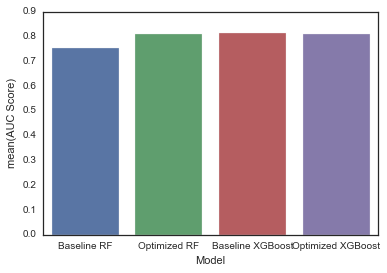

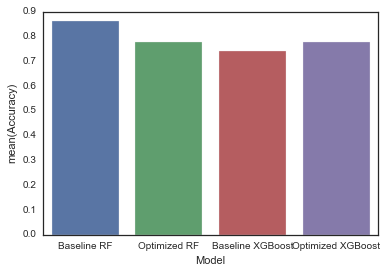

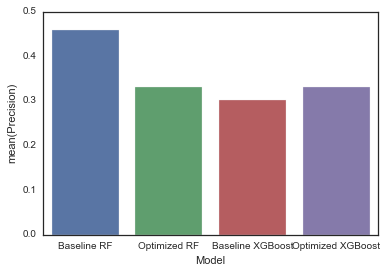

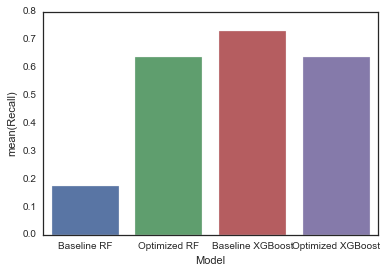

In [501]:
viz_r.barplot(x = 'Model', y = 'AUC Score')
plt.show()
viz_r.barplot(x = 'Model', y = 'Accuracy')
plt.show()
viz_r.barplot(x = 'Model', y = 'Precision')
plt.show()
viz_r.barplot(x = 'Model', y = 'Recall')
